This notebook serves as the Deep Bayesian Active Learning paper implementation based on:
- https://github.com/damienlancry/DBAL/blob/master/dbal_pytorch.ipynb
- https://github.com/wohlert/semi-supervised-pytorch/blob/master/examples/notebooks/Deep%20Generative%20Model.ipynb

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

DATASET = "MNIST"
# Set number of initial labelled data per class
INITIAL_LABEL_PER_CLASS = 10
N_LABELS = 10 #MNIST
SEED = 420

PIXEL = 32 if DATASET == "CIFAR10" else 28
CHANNELS = 3 if DATASET == "CIFAR10" else 28
BASE_DIR = '.'

In [ ]:
# For Colab
# !pip install skorch modAL torchsummary torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Let's start with a bunch of imports.

import random
from copy import deepcopy
from dataclasses import dataclass

import numpy as np
import torch
import torch.backends
from torch import optim
from torch.hub import load_state_dict_from_url
from torch.nn import CrossEntropyLoss
from torchvision import datasets
from torchvision import models
from torchvision.transforms import transforms

In [ ]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from skorch import NeuralNetClassifier
from modAL.models import ActiveLearner
from torchsummary import summary
import pickle
import random

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
import sys

In [ ]:
# For Colab to mount semi-supervised folder
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Use cuda if available
cuda = torch.cuda.is_available()
# Add a semi supervised module
# For Colab
sys.path.insert(0, f'{BASE_DIR}/semi-supervised') # Adjust if Colab is used instead

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
set_seed(SEED)

### Network Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self, dataset="MNIST"):
        super(CNN, self).__init__()
        self.dataset = dataset
        if dataset in ("MNIST", "FASHION"):
            self.convs = nn.Sequential(
                            nn.Conv2d(1, 32, 4),
                            nn.ReLU(),
                            nn.Conv2d(32, 32, 4),
                            nn.ReLU(),
                            nn.MaxPool2d(2),
                            nn.Dropout(0.25),
                            nn.Flatten(),
                            nn.Linear(11*11*32, 128),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(128, 10)
                        )
        elif dataset == "CIFAR10":
            self.convs = nn.Sequential(
                        nn.Conv2d(3, 32, 4),
                        nn.ReLU(),
                        nn.Conv2d(32, 32, 4),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Dropout(0.25),
                        nn.Flatten(),
                        nn.Linear(13*13*32, 128),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(128, 10)
                    )

    def forward(self, x):
        if len(x.shape) != 2:
            out = x
        else:
            if self.dataset in ("MNIST", "FASHION"):
                out = x.reshape(-1, 1, 28, 28)
            elif self.dataset == "CIFAR10":
                out = x.reshape(-1, 3, 32, 32)
        out = self.convs(out)
        out = F.softmax(out, dim=-1)
        return out

In [ ]:
if DATASET in ("MNIST", "FASHION"):
    summary(CNN().convs, (1,28,28), device="cpu")
elif DATASET == "CIFAR10":
    summary(CNN("CIFAR10").convs, (3,32,32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 25, 25]             544
              ReLU-2           [-1, 32, 25, 25]               0
            Conv2d-3           [-1, 32, 22, 22]          16,416
              ReLU-4           [-1, 32, 22, 22]               0
         MaxPool2d-5           [-1, 32, 11, 11]               0
           Dropout-6           [-1, 32, 11, 11]               0
           Flatten-7                 [-1, 3872]               0
            Linear-8                  [-1, 128]         495,744
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 513,994
Trainable params: 513,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
if DATASET == "MNIST":
    train = MNIST('.', train=True, download=True, transform=ToTensor())
    test = MNIST('.', train=False, download=True, transform=ToTensor())
    train_data_loader = DataLoader(train, shuffle = True, batch_size = 60_000)
    test_data_loader = DataLoader(test, shuffle = True, batch_size = 10_000)
elif DATASET == "FashionMNIST":
    train = FashionMNIST('.', train=True, download=True, transform=ToTensor())
    test = FashionMNIST('.', train=False, download=True, transform=ToTensor())
    train_data_loader = DataLoader(train, shuffle = True, batch_size = 60_000)
    test_data_loader = DataLoader(test, shuffle = True, batch_size = 10_000)
elif DATASET == "CIFAR10":
    train = CIFAR10('.', train=True, download=True, transform=ToTensor())
    test = CIFAR10('.', train=False, download=True, transform=ToTensor())
    train_data_loader = DataLoader(train, shuffle = True, batch_size = 50_000)
    test_data_loader = DataLoader(test, shuffle = True, batch_size = 10_000)


X_train, y_train = next(iter(train_data_loader))
X_train = X_train.detach().cpu().numpy()
y_train = y_train.detach().cpu().numpy()

X_test, y_test = next(iter(test_data_loader))
X_test = X_test.detach().cpu().numpy()
y_test = y_test.detach().cpu().numpy()


## Preprocessing

In [ ]:
if DATASET == "CIFAR10":
    X_train = X_train.reshape(50_000, 3, 32, 32)
    X_test = X_test.reshape(10_000, 3, 32, 32)
else:
    X_train = X_train.reshape(60_000, 1, 28, 28)
    X_test = X_test.reshape(10_000, 1, 28, 28)

In [ ]:
# Create initial labelled data
# Take INITIAL_LABELLED_PER_CLASS samples from each digit
initial_labelled_idx = np.array([],dtype=np.int64)
for i in range(N_LABELS):
    idx = np.random.choice(np.where(y_train==i)[0], size=INITIAL_LABEL_PER_CLASS, replace=False)
    initial_labelled_idx = np.concatenate((initial_labelled_idx, idx))

X_train_labelled_initial = X_train[initial_labelled_idx]
y_train_labelled_initial = y_train[initial_labelled_idx]

In [ ]:
# Create a pool of unlabelled data
X_train_unlabelled = np.delete(X_train, initial_labelled_idx, axis = 0)
y_train_unlabelled = np.delete(y_train, initial_labelled_idx, axis = 0)

### Query Strategies

#### Random (Uniform)

In [ ]:
def uniform(learner, X, n_instances = 1):
    query_idx = np.random.choice(range(len(X)), size = n_instances, replace = False)
    return query_idx, X[query_idx]

#### Bald

In [ ]:
def bald(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=2000, replace=False)
    with torch.no_grad():
        outputs = np.stack([learner.estimator.forward(X[random_subset], training=True).cpu().numpy()
                            for t in range(100)])
    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)  # [batch size]
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]    


### Active Learning 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

query_strategies = {'random':{'function':uniform,
                                'classifier': None,
                                'learner': None,
                                'performance_history': None},
                    'bald':{'function':bald,
                                'classifier': None,
                                'learner': None,
                                'performance_history': None},
                    }

In [ ]:
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              n_queries=1000,
                              n_instances=1,
                              query_strategy_label=''):
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                           )
    perf_hist = [learner.score(X_test, y_test)]
    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test)
        print('{q}Accuracy after query {n}: {acc:0.4f}'.format(q=f'[{query_strategy_label}] ', n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)

    # Save after-query labelled and unlabelled data
    torch.save(learner.X_training, f'{BASE_DIR}/saved_data/{DATASET}_X_train_labelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.pt')
    torch.save(learner.y_training, f'{BASE_DIR}/saved_data/{DATASET}_y_train_labelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.pt')

    torch.save(X_pool, f'{BASE_DIR}/saved_data/{DATASET}_X_train_unlabelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.pt')
    torch.save(y_pool, f'{BASE_DIR}/saved_data/{DATASET}_y_train_unlabelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.pt')

    return learner, perf_hist

In [ ]:
for query_strategy_name, query_strategy in query_strategies.items():
    query_strategy['classifier'] = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
    query_strategy['learner'], query_strategy['performance_history'] = active_learning_procedure(query_strategy['function'],
                                                X_test,
                                                y_test,
                                                X_train_unlabelled,
                                                y_train_unlabelled,
                                                X_train_labelled_initial,
                                                y_train_labelled_initial,
                                                query_strategy['classifier'],
                                                query_strategy_label=query_strategy_name)

[random] Accuracy after query 1: 0.4457
[random] Accuracy after query 2: 0.4456
[random] Accuracy after query 3: 0.4610
[random] Accuracy after query 4: 0.4550
[random] Accuracy after query 5: 0.3708
[random] Accuracy after query 6: 0.4806
[random] Accuracy after query 7: 0.4983
[random] Accuracy after query 8: 0.4239
[random] Accuracy after query 9: 0.3990
[random] Accuracy after query 10: 0.4508
[random] Accuracy after query 11: 0.5020
[random] Accuracy after query 12: 0.5642
[random] Accuracy after query 13: 0.5129
[random] Accuracy after query 14: 0.5838
[random] Accuracy after query 15: 0.4755
[random] Accuracy after query 16: 0.4638
[random] Accuracy after query 17: 0.4609
[random] Accuracy after query 18: 0.4372
[random] Accuracy after query 19: 0.4705
[random] Accuracy after query 20: 0.4731
[random] Accuracy after query 21: 0.4474
[random] Accuracy after query 22: 0.4759
[random] Accuracy after query 23: 0.4762
[random] Accuracy after query 24: 0.4740
[random] Accuracy after q

In [ ]:
# Save models and data
performance_histories = {}
for query_strategy_name, query_strategy in query_strategies.items():
    # Save classifiers
    query_strategy['classifier'].save_params(f_params=f'{BASE_DIR}/saved_models/{DATASET}_{query_strategy_name}_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.pkl')

    # Save data after queries:
    # torch.save(query_strategy['learner'].X_training, f'./saved_data/X_training_{query_strategy_name}.pt')
    # torch.save(query_strategy['learner'].y_training, f'./saved_data/y_training_{query_strategy_name}.pt')

# Save initial labelled and unlabelled data
X_train_labelled_initial = X_train[initial_labelled_idx]
y_train_labelled_initial = y_train[initial_labelled_idx]
torch.save(X_train_labelled_initial, f'{BASE_DIR}/saved_data/{DATASET}_X_train_labelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.pt')
torch.save(y_train_labelled_initial, f'{BASE_DIR}/saved_data/{DATASET}_y_train_labelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.pt')
torch.save(X_train_unlabelled, f'{BASE_DIR}/saved_data/{DATASET}_X_train_unlabelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.pt')
torch.save(y_train_unlabelled, f'{BASE_DIR}/saved_data/{DATASET}_y_train_unlabelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.pt')

# Save test data
torch.save(X_test, f'{BASE_DIR}/saved_data/{DATASET}_X_test_{SEED}.pt')
torch.save(y_test, f'{BASE_DIR}/saved_data/{DATASET}_y_test_{SEED}.pt')

# Save performance histories (preprocessing)
performance_histories = {query_strategy_name: query_strategy['performance_history'] for query_strategy_name, query_strategy in query_strategies.items()}
pd.DataFrame(performance_histories).to_csv(f'{BASE_DIR}/saved_data/{DATASET}_active_learning_performance_histories_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.csv')


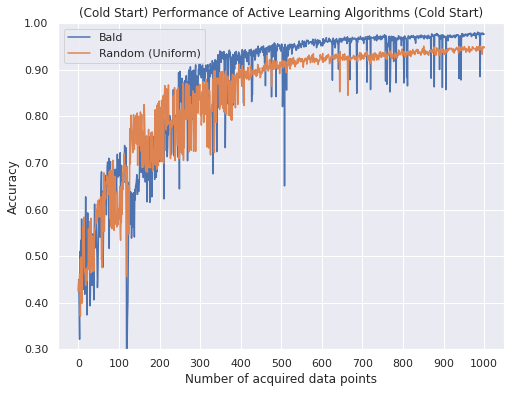

In [ ]:
# Plot
sns.set()
# plt.plot(query_strategies['max_entropy']['performance_history'], label="max entropy")
fig, ax = plt.subplots(figsize=(8, 6))

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1001, 100)
ax.set_xticks(major_ticks)

x_ticks = np.arange(0, 1001, 1)
ax.plot(x_ticks, query_strategies['bald']['performance_history'], label="Bald")
ax.plot(x_ticks, query_strategies['random']['performance_history'], label="Random (Uniform)")
ax.set_ylim([0.3,1])

ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of acquired data points")
ax.set_title("Performance of Active Learning Algorithms")
ax.legend()


###  Semi-supervised Learning

<img src="https://github.com/milexjaro/semi-supervised-active-learning-pytorch/blob/main/images/dgm.png?raw=1" width="400px"/>

## Progressive Setting

In [ ]:
from models import DeepGenerativeModel
from datautils import get_dataset
from itertools import cycle
from inference import SVI, ImportanceWeightedSampler
from torch.autograd import Variable

SSL_EPOCHS = 50

def binary_cross_entropy(y_pred, y):
    return -torch.sum(y * torch.log(y_pred + 1e-8) + (1 - y) * torch.log(1 - y_pred + 1e-8), dim=-1)


x_dim = CHANNELS * PIXEL * PIXEL
y_dim = N_LABELS
z_dim = 32
h_dim = [256, 128]

SSL_metrics = {'random':{'train_loss_history':None,
                                'train_accuracy_history': None,
                                'test_loss_history': None,
                                'test_accuracy_history': None},
                    'bald':{'train_loss_history':None,
                                'train_accuracy_history': None,
                                'test_loss_history': None,
                                'test_accuracy_history': None},
                    }

In [ ]:
def calculate_J_alpha(x, y, u, alpha, model):
    # Calculate ELBOs
    L = -elbo(x, y)
    U = -elbo(u)

    # Add auxiliary classification loss q(y|x)
    logits = model.classify(x)
    
    # Regular cross entropy
    classification_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

    J_alpha = L + alpha * classification_loss + U

    return J_alpha, logits

In [ ]:
from torch.autograd import Variable


SSL_progressive_performance = {'random':[],
                                'bald':[]}

start_cap = INITIAL_LABEL_PER_CLASS * N_LABELS
for cap in range(start_cap,start_cap+1001,100):
    SSL_metrics = {'random':{'train_loss_history':None,
                                'train_accuracy_history': None,
                                'test_loss_history': None,
                                'test_accuracy_history': None},
                    'bald':{'train_loss_history':None,
                                'train_accuracy_history': None,
                                'test_loss_history': None,
                                'test_accuracy_history': None},
                    }
    for algorithm in SSL_metrics.keys():
        
        # Only use INITIAL_LABEL_PER_CLASS labelled examples per class
        # The rest of the data is unlabelled.
        labelled, unlabelled, test = get_dataset(location="{BASE_DIR}/saved_data", dataset = DATASET, seed = SEED, batch_size=64,
                                    labels_per_class=INITIAL_LABEL_PER_CLASS, algorithm=algorithm, data_size_cap=cap)

        # Prepare the model and the optimizer
        model = DeepGenerativeModel([x_dim, y_dim, z_dim, h_dim])

        if cuda: model = model.cuda()
        alpha = 0.1 * len(unlabelled) / len(labelled)
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

        # Prepare a sampler and the elbo object
        # You can use importance weighted samples [Burda, 2015] to get a better estimate
        # on the log-likelihood.
        sampler = ImportanceWeightedSampler(mc=1, iw=1)
        elbo = SVI(model, likelihood=binary_cross_entropy, sampler=sampler)


        SSL_train_loss_history = []
        SSL_train_accuracy_history = []
        SSL_test_loss_history = []
        SSL_test_accuracy_history = []

        for epoch in range(SSL_EPOCHS):
            model.train()
            total_loss, accuracy = (0, 0)
            for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
                # Wrap in variables
                x, y, u = Variable(x).cuda(device=0), Variable(y).cuda(device=0), Variable(u).cuda(device=0)

                J_alpha, logits = calculate_J_alpha(x.reshape(-1, CHANNELS * PIXEL * PIXEL), y, u, alpha, model)

                J_alpha.backward()
                optimizer.step()
                optimizer.zero_grad()

                total_loss += J_alpha.data
                accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
                
            if epoch % 1 == 0:
                model.eval()
                m = len(unlabelled)

                train_loss = total_loss/m
                train_accuracy = accuracy/m

                SSL_train_loss_history.append(train_loss)
                SSL_train_accuracy_history.append(train_accuracy)
                print("Dataset: {}, Seed: {}, Algorithm: {}, Cap: {}".format(DATASET, SEED, algorithm, cap))
                print("Epoch: {}".format(epoch))
                print("[Train]\t J_a: {:.2f}, accuracy: {:.2f}".format(train_loss, train_accuracy))

                total_loss, accuracy = (0, 0)
                for x, y in test:
                    x, y = Variable(x).cuda(device=0), Variable(y).cuda(device=0)

                    J_alpha, logits = calculate_J_alpha(x.reshape(-1, CHANNELS * PIXEL * PIXEL), y, x.reshape(-1, CHANNELS * PIXEL * PIXEL), alpha, model)

                    total_loss += J_alpha.data

                    _, pred_idx = torch.max(logits, 1)
                    _, lab_idx = torch.max(y, 1)
                    accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

                m = len(test)

                test_loss = total_loss/m
                test_accuracy = accuracy/m

                SSL_test_loss_history.append(test_loss)
                SSL_test_accuracy_history.append(test_accuracy)

                print("[Test]\t J_a: {:.2f}, accuracy: {:.4f}".format(test_loss, test_accuracy))

        SSL_metrics[algorithm]['train_loss_history'] = [x.item() for x in SSL_train_loss_history]
        SSL_metrics[algorithm]['train_accuracy_history'] = [x.item() for x in SSL_train_accuracy_history]
        SSL_metrics[algorithm]['test_loss_history'] = [x.item() for x in SSL_test_loss_history]
        SSL_metrics[algorithm]['test_accuracy_history'] = [x.item() for x in SSL_test_accuracy_history]
        
        SSL_progressive_performance[algorithm].append(SSL_metrics[algorithm]['test_accuracy_history'][-1])

/content/drive/MyDrive/UCL/Dissertation/saved_data/MNIST_X_train_labelled_random_10_420.pt
/content/drive/MyDrive/UCL/Dissertation/saved_data/MNIST_y_train_labelled_random_10_420.pt
10 10
/content/drive/MyDrive/UCL/Dissertation/saved_data/MNIST_X_train_unlabelled_random_10_420.pt
/content/drive/MyDrive/UCL/Dissertation/saved_data/MNIST_y_train_unlabelled_random_10_420.pt
59990 59990
/content/drive/MyDrive/UCL/Dissertation/saved_data/MNIST_X_test_420.pt
/content/drive/MyDrive/UCL/Dissertation/saved_data/MNIST_y_test_420.pt
10000 10000
Dataset: MNIST, Seed: 420, Algorithm: random, Cap: 10
Epoch: 0
[Train]	 J_a: 298.34, accuracy: 0.99
[Test]	 J_a: 577.85, accuracy: 0.5025
Dataset: MNIST, Seed: 420, Algorithm: random, Cap: 10
Epoch: 1
[Train]	 J_a: 200.45, accuracy: 1.00
[Test]	 J_a: 639.21, accuracy: 0.5055
Dataset: MNIST, Seed: 420, Algorithm: random, Cap: 10
Epoch: 2
[Train]	 J_a: 184.35, accuracy: 1.00
[Test]	 J_a: 762.21, accuracy: 0.5012
Dataset: MNIST, Seed: 420, Algorithm: random, 

In [ ]:
pd.DataFrame(SSL_progressive_performance).to_csv(f'{BASE_DIR}/saved_data/{DATASET}_SSL_progressive_performance_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.csv')

## Performance Plot (AL-SSL)

In [ ]:
SSL_perf_df = pd.read_csv(f'{BASE_DIR}/saved_data/{DATASET}_SSL_progressive_performance_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.csv')
AL_perf_df = pd.read_csv(f'{BASE_DIR}/saved_data/{DATASET}_active_learning_performance_histories_{N_LABELS*INITIAL_LABEL_PER_CLASS}_{SEED}.csv').loc[range(0,1001, 100)]

In [ ]:
SSL_perf_df['bald']

0     0.565486
1     0.953722
2     0.947154
3     0.967357
4     0.968750
5     0.976413
6     0.975119
7     0.981091
8     0.979896
9     0.982683
10    0.980096
Name: bald, dtype: float64

In [ ]:
SSL_perf_df['random']

0     0.576732
1     0.892516
2     0.949940
3     0.957205
4     0.959295
5     0.959992
6     0.964271
7     0.962679
8     0.965665
9     0.965167
10    0.966859
Name: random, dtype: float64

In [ ]:
AL_perf_df['random']

0       0.4238
100     0.6022
200     0.7069
300     0.8561
400     0.8857
500     0.9112
600     0.9211
700     0.9318
800     0.9389
900     0.9437
1000    0.9487
Name: random, dtype: float64

In [ ]:
AL_perf_df['bald']

0       0.4267
100     0.6726
200     0.7569
300     0.9121
400     0.9019
500     0.9480
600     0.9576
700     0.9639
800     0.9644
900     0.9697
1000    0.9763
Name: bald, dtype: float64

Text(0.5, 0.98, 'Performance of Active Learning (AL) vs Active Learning Semi-Supervised Learning (AL SSL)')

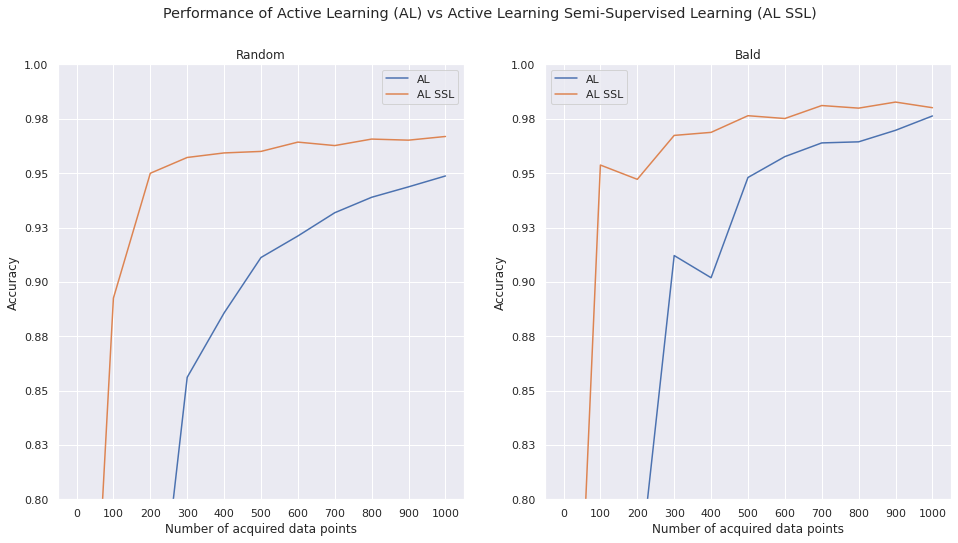

In [ ]:
# Plot the SSL-AL Performance
# Plot
sns.set()


fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,
                                    figsize=(16, 8))

# Set y axis format
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1001,100)
ax0.set_xticks(major_ticks)

x_ticks = np.arange(0, 1001,100)
ax0.plot(x_ticks, AL_perf_df['random'], label = 'AL')
ax0.plot(x_ticks, SSL_perf_df['random'], label = 'AL SSL')
ax0.set_title('Random')
ax0.set_ylim([0.8,1])
ax0.set_ylabel("Accuracy")
ax0.set_xlabel("Number of acquired data points")
ax0.legend()

# Set y axis format
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1001,100)
ax1.set_xticks(major_ticks)

x_ticks = np.arange(0, 1001,100)
ax1.plot(x_ticks, AL_perf_df['bald'], label = 'AL')
ax1.plot(x_ticks, SSL_perf_df['bald'], label = 'AL SSL')
ax1.set_title('Bald')
ax1.set_ylim([0.8,1])
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Number of acquired data points")
ax1.legend()

fig.suptitle("Performance of Active Learning (AL) vs Active Learning Semi-Supervised Learning (AL SSL)")


Text(0.5, 0.98, '(Cold Start) Performance of Active Learning (AL) vs Active Learning Semi-Supervised Learning (AL-SSL)')

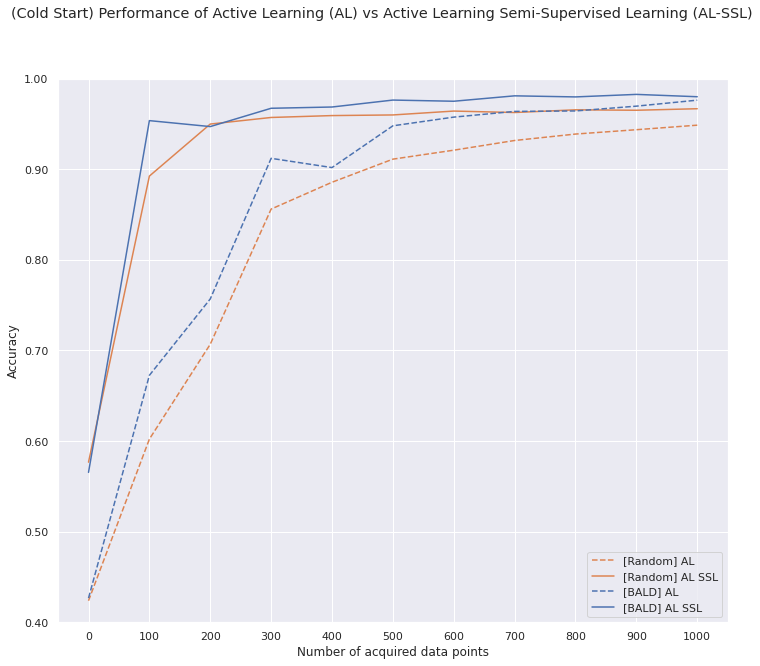

In [ ]:
# Plot the SSL-AL Performance
sns.set()


fig, (ax0) = plt.subplots(
                                    figsize=(12, 10))

# Set y axis format
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1001,100)
ax0.set_xticks(major_ticks)

x_ticks = np.arange(0, 1001,100)
ax0.plot(x_ticks, AL_perf_df['random'], '--', label = '[Random] AL', color =(0.8666666666666667, 0.5176470588235295, 0.3215686274509804))
ax0.plot(x_ticks, SSL_perf_df['random'], '-', label = '[Random] AL SSL', color =(0.8666666666666667, 0.5176470588235295, 0.3215686274509804))
ax0.plot(x_ticks, AL_perf_df['bald'], '--', label = '[BALD] AL', color =(0.2980392156862745, 0.4470588235294118, 0.6901960784313725))
ax0.plot(x_ticks, SSL_perf_df['bald'], '-', label = '[BALD] AL SSL', color =(0.2980392156862745, 0.4470588235294118, 0.6901960784313725))
ax0.set_ylim([0.4,1])
ax0.set_ylabel("Accuracy")
ax0.set_xlabel("Number of acquired data points")
ax0.legend()

fig.suptitle("Performance of Active Learning (AL) vs Active Learning Semi-Supervised Learning (AL-SSL)")
